In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
df_train = pd.read_csv('/content/drive/MyDrive/Redes Neurais/Github/Redes-Neurais/Titanic/train.csv')

#Simplista tirar o NAN

df_train = df_train.dropna()

### Tratar a base

In [6]:
df_train.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True


In [7]:
y = df_train[['Transported']]
y['Transported'] = y['Transported'].apply(lambda x: 1 if x == True else 0)

train = df_train.drop(columns = ['PassengerId', 'Name', 'Transported'])

## Dummie dos categóricos (testar sem dummies fazendo os encoders dentro da coluna)

train = pd.concat((train, pd.get_dummies(train[['HomePlanet', 'CryoSleep', 'Destination', 'VIP']])), axis=1)
train = train.drop(['HomePlanet', 'CryoSleep', 'Destination', 'VIP'],axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
## Parte de tratamento das cabines. Pode ignorar

train = train.drop(train['Cabin'][train['Cabin'] == 'NoneCabin'].index, axis=0)
train['Cabin'] = train['Cabin'].fillna(train['Cabin'].mode()[0])

first, sec, thrd = [], [], []
mem = []
for i in range(train['Cabin'].shape[0]):
    mem = train['Cabin'].iloc[i].split('/')
    first.append(mem[0])
    sec.append(mem[1])
    thrd.append(mem[2])
first = pd.Series(first)
first.index = train['Cabin'].index
sec = pd.Series(sec)
sec.index = train['Cabin'].index
thrd = pd.Series(thrd) 
thrd.index = train['Cabin'].index
train['CabinClass'] = first
train['CabinNumber'] = sec
train['CabinSeat'] = thrd

'''first, sec, thrd = [], [], []
mem = []
for i in range(test['Cabin'].shape[0]):
    mem = test['Cabin'].iloc[i].split('/')
    first.append(mem[0])
    sec.append(mem[1])
    thrd.append(mem[2])
first = pd.Series(first)
first.index = test['Cabin'].index
sec = pd.Series(sec)
sec.index = test['Cabin'].index
thrd = pd.Series(thrd) 
thrd.index = test['Cabin'].index
test['CabinClass'] = first
test['CabinNumber'] = sec
test['CabinSeat'] = thrd'''

train = train.drop('Cabin',axis=1)
'''test = test.drop('Cabin',axis=1)

test.dtypes[(test.dtypes == "object") == True].index.tolist()

test.dtypes[(test.dtypes != "object") == True].index.tolist() == train.dtypes[(train.dtypes != "object") == True].index.tolist()
'''
train = pd.concat((train, pd.get_dummies(train['CabinClass'])), axis=1)
train = pd.concat((train, pd.get_dummies(train['CabinSeat'])), axis=1)
train = train.drop(['CabinClass','CabinSeat'],axis=1)

In [9]:
### Normalizar

transformer = Normalizer().fit(train) 
transformer
train=transformer.transform(train)


#Splitar em treinamento e teste

x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.3)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4624, 27)
(4624, 1)
(1982, 27)
(1982, 1)


###Estrutura da rede

In [16]:
model = Sequential() 
model.add(Dense(32, activation='relu', input_dim=train.shape[1]))
model.add(Dense(32, activation='relu', input_dim=train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy']) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                896       
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________


In [147]:
hist=model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=150)

Epoch 1/150
145/145 [==============================] - 1s 4ms/step - loss: 0.5995 - accuracy: 0.7204 - val_loss: 0.5164 - val_accuracy: 0.7780
Epoch 2/150
145/145 [==============================] - 0s 3ms/step - loss: 0.5007 - accuracy: 0.7891 - val_loss: 0.4855 - val_accuracy: 0.7982
Epoch 3/150
145/145 [==============================] - 0s 3ms/step - loss: 0.4916 - accuracy: 0.7911 - val_loss: 0.4833 - val_accuracy: 0.8012
Epoch 4/150
145/145 [==============================] - 0s 3ms/step - loss: 0.4892 - accuracy: 0.7946 - val_loss: 0.4788 - val_accuracy: 0.8037
Epoch 5/150
145/145 [==============================] - 0s 3ms/step - loss: 0.4842 - accuracy: 0.7943 - val_loss: 0.4765 - val_accuracy: 0.8027
Epoch 6/150
145/145 [==============================] - 0s 3ms/step - loss: 0.4841 - accuracy: 0.7956 - val_loss: 0.4744 - val_accuracy: 0.8042
Epoch 7/150
145/145 [==============================] - 0s 3ms/step - loss: 0.4803 - accuracy: 0.7982 - val_loss: 0.4744 - val_accuracy: 0.8052

[]

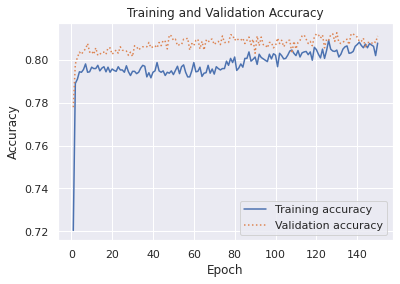

In [148]:
sns.set()
 
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

###Adicionar visualizações de métricas

In [91]:
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

res = []

metrics_to_plot = [
    ("loss", "loss"),
    ("precision", "Precision"),
    ("recall", "Recall"),
    ("auc", "Area under ROC curve"),
    ("prc", "Area under PR curve"),
]

metrics_to_plot_2 = [
    ("loss", "loss"),
    ("accuracy", "Precision")
]
fig = make_subplots(rows=len(metrics_to_plot_2), cols=1)

for metric, name in metrics_to_plot_2:
    fig = go.Figure(
        data=[
            go.Scatter(
                x=hist.epoch,
                y=hist.history[f'{metric}'],
                mode="lines",
                name="Training",
            ),
            go.Scatter(
                x=hist.epoch,
                y=hist.history['val_'+ f'{metric}'],
                mode="lines",
                line={"dash": "dash"},
                name="Validation",
            ),
        ]
    )
    fig.update_yaxes(title=name)
    fig.update_xaxes(title="Epoch")

    if (metric, name) == metrics_to_plot[0]:
        fig.update_layout(
            height=250, title="Training history", margin={"b": 0, "t": 50}
        )
    else:
        fig.update_layout(height=200, margin={"b": 0, "t": 0})
    fig.show()